In [1]:
################################################################################
#######################    Time series decomposition    ########################
################################################################################
### Load necessary modules -------------------------------
from dateutil.parser import parse 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import ForecastingTools as FT
import seaborn as sns
import scipy.stats as st
from statsmodels.tsa.stattools import adfuller

In [2]:
# Import data
df = pd.read_excel('SARIMA.xls')
df.head()

,SO2,NO2
0,35.56,50.916667
1,21.73,42.583333
2,26.17,45.083333
3,45.90,59.708333
4,27.52,54.291667


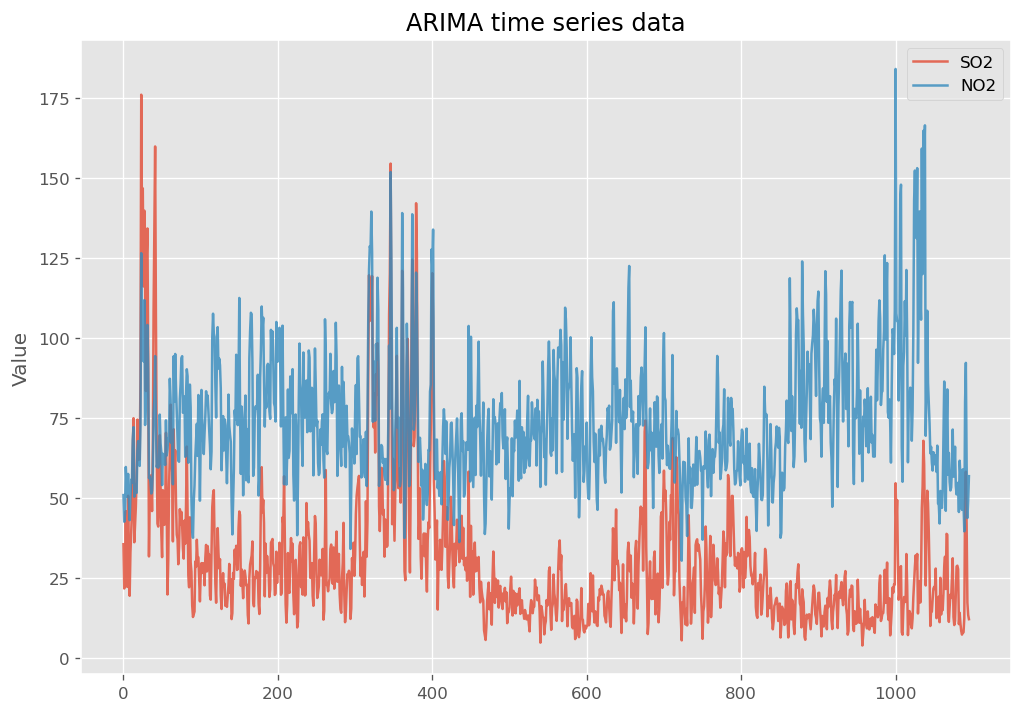

In [3]:
# Plotting a time series
fig, ax = plt.subplots()
for col in df.columns.values.tolist():
    ax.plot(col, data=df, label=col, alpha=0.8)
ax.set(title='ARIMA time series data', ylabel='Value')
plt.legend()
plt.show()

In [4]:
df_ts = df[['NO2']] # Maintain data.frame format for column
df_ts

,NO2
0,50.916667
1,42.583333
2,45.083333
3,59.708333
4,54.291667
...,...
1091,92.250000
1092,60.583333
1093,43.750000
1094,49.125000


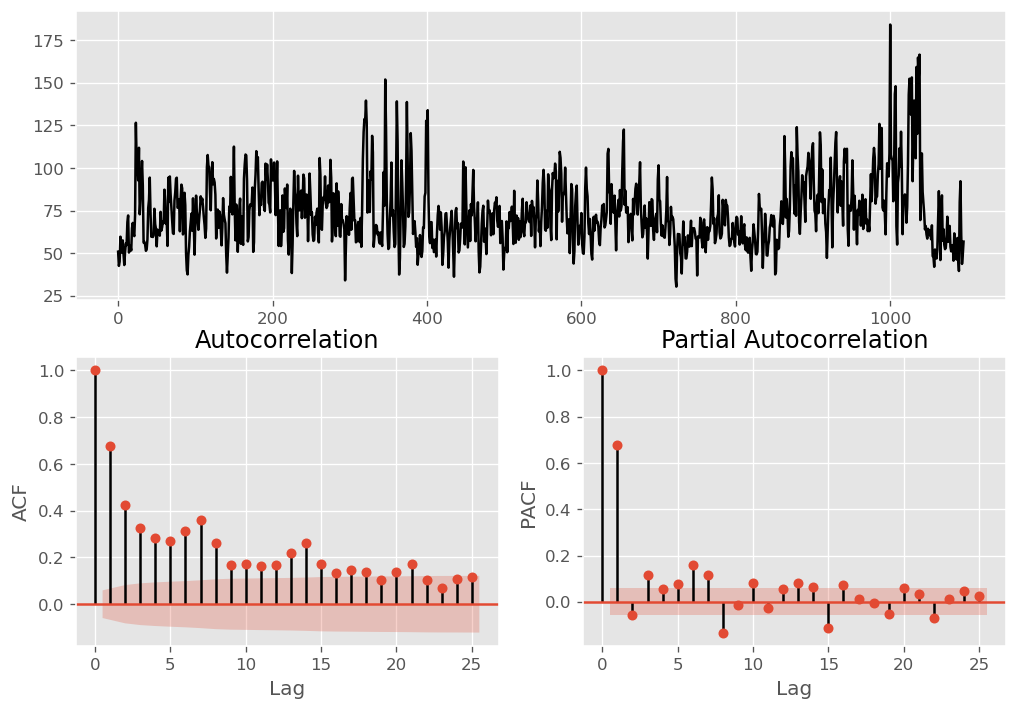

In [5]:
## Identification frocess 
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(df_ts)

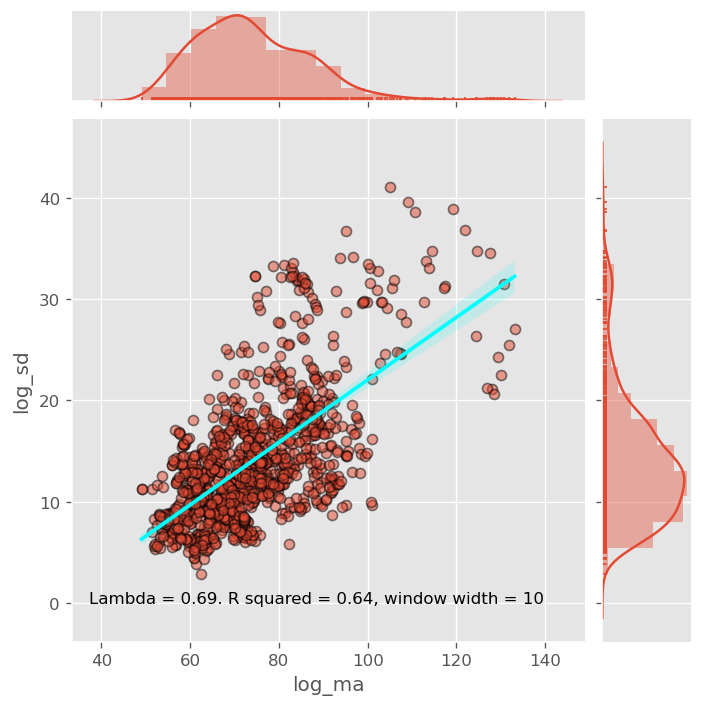

In [6]:
# Box-Cox transformation
FT.boxcox_lambda_plot(df_ts, window_width=10)

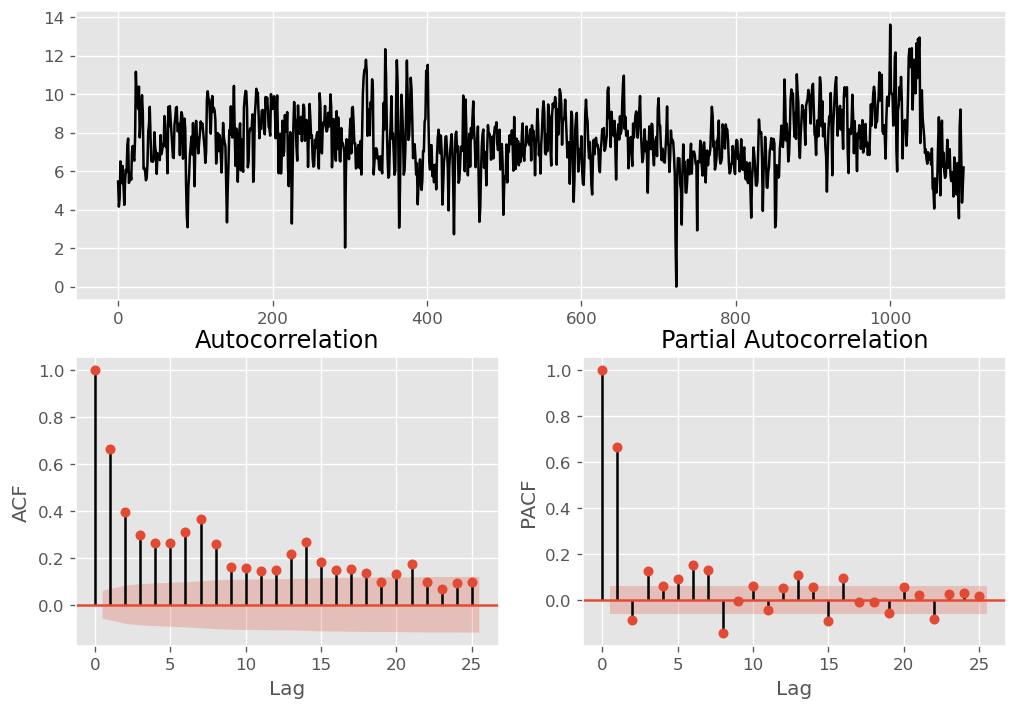

In [93]:
# Plot transformed data
z, lambd = st.boxcox(df_ts.values[:,0] - min(df_ts.values) + 1)
z = pd.DataFrame(z, columns=df_ts.columns.values.tolist())
FT.ts_display(z)

In [94]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.896271
p-value: 0.000035
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


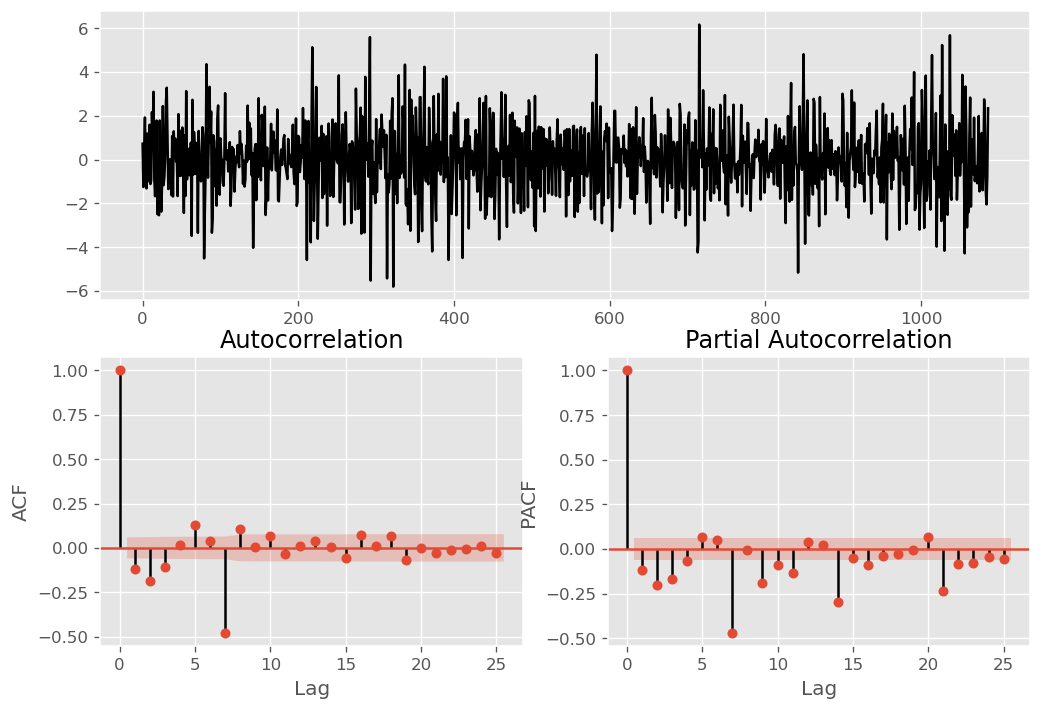

In [95]:
# Difference of the time series
d = 1
Bz = z
for diff in range(d):
    Bz = Bz.diff().loc[1:] # drop first NA value
    Bz = Bz.reset_index()[['NO2']]
S = 7 # Seasonality of 7 days
D = 1
for seas_diff in range(D):
    Bz = Bz.diff(S).loc[S+1:] # drop first NA values
    Bz = Bz.reset_index()[['NO2']]
FT.ts_display(Bz)

In [101]:
# Fit model with estimated order
# If you want to apply Boxcox
boxcox = False
# Regular components
p = 1
d = 1
q = 0
# Seasonal components
P = 1
D = 1
Q = 0
S = 7
# Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
t = 'ct'
if boxcox:
    sarima_fit = SARIMAX(z, 
                       order=(p,d,q),
                       seasonal_order=(P, D, Q, S),
                       trend=t,
                       enforce_invertibility=False, 
                       enforce_stationarity=False).fit(disp=0)
else:
    sarima_fit = SARIMAX(df_ts, 
                       order=(p,d,q),
                       seasonal_order=(P, D, Q, S),
                       trend=t,
                       enforce_invertibility=False, 
                       enforce_stationarity=False).fit(disp=0)

print(sarima_fit.summary())

SARIMAX Results                                     
Dep. Variable:                               NO2   No. Observations:                 1096
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 7)   Log Likelihood               -4621.227
Date:                           Mon, 24 Aug 2020   AIC                           9252.454
Time:                                   19:11:49   BIC                           9277.378
Sample:                                        0   HQIC                          9261.891
                                          - 1096                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0163      1.091     -0.015      0.988      -2.154       2.121
drift       2.852e-05      0.002      0.018      0.986      -0.003       0.003
a

Ljung-Box test of residuals:
       lb_stat     lb_pvalue
25  249.749338  6.059390e-39


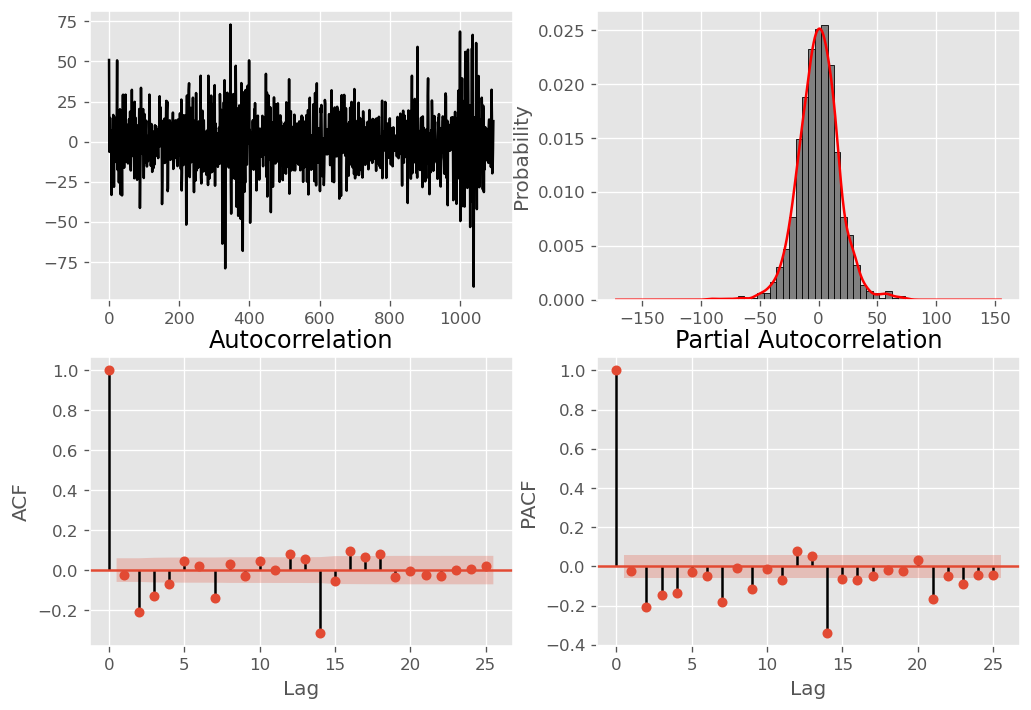

In [102]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid))

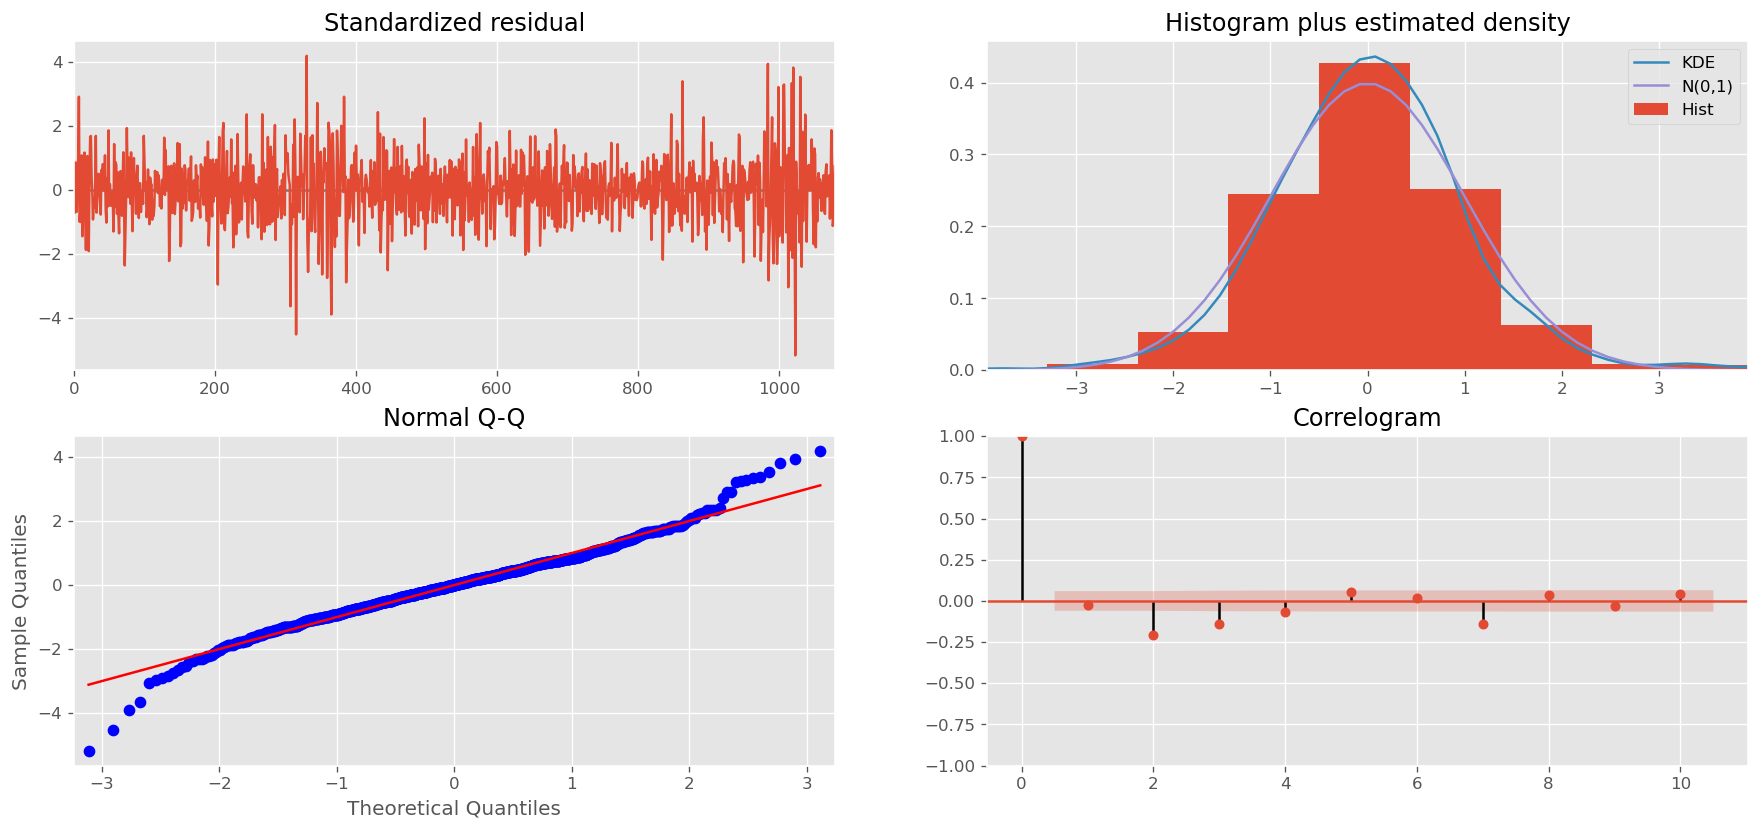

In [103]:
sarima_fit.plot_diagnostics(figsize=(18, 8))
plt.show()

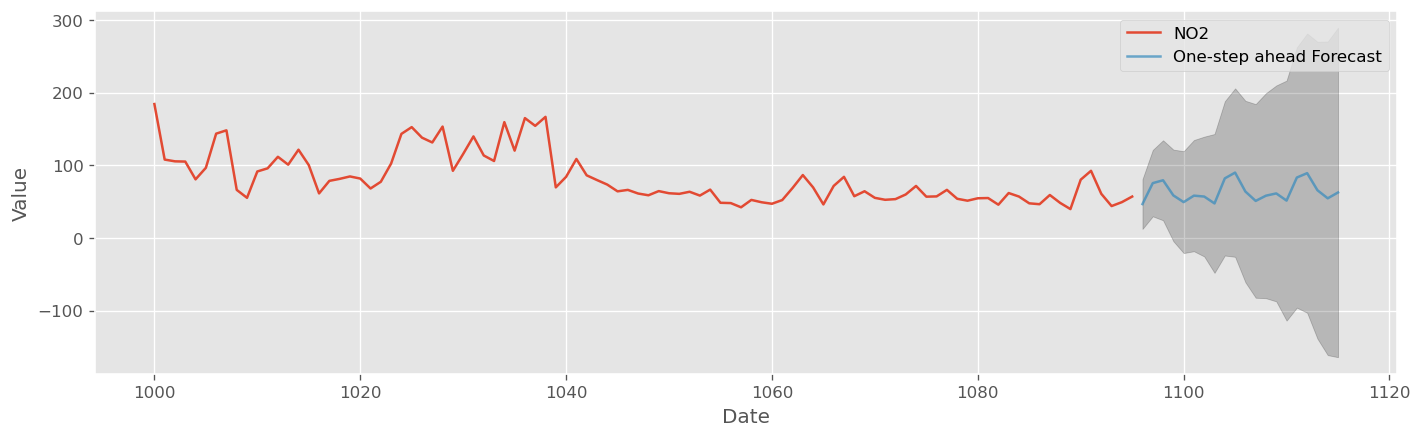

In [118]:
# Plot prediction and confidence intervals
# If using dynamic = True, the forecast are used as real data
horizon = 20
start = 1000
pred = sarima_fit.get_forecast(steps=horizon, dynamic=True)
pred_ci = pred.conf_int()
ax = df_ts.iloc[start:].plot(label='observed')
if boxcox:
    FT.inverse_box_cox(pred.predicted_mean,lambd).plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
else:
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()
plt.show()